In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "structural_ph_outputs.csv"

# Load structural PH outputs

df = pd.read_csv(DATA_PATH, parse_dates=["start_date", "end_date"])

# canonical timestamp = window end
df = df.rename(columns={"end_date": "date"})
df = df.sort_values("date").reset_index(drop=True)

print("Rows:", len(df))
print("Assets:", sorted(df["asset"].unique()))
print("Date range:", df["date"].min(), "→", df["date"].max())
print("Cols:", df.columns.tolist())

# Choosing systems for coherence

TOP_SYSTEMS = [
    "Fed Funds",
    "HY OAS",
    "Gold (XAU)",
    "Silver",
    "Yield Curve (10y–2y)",
]

ERA = "Full"  # or "Post-1971" if you want stricter modern-only
df = df[df["era"] == ERA].copy()

missing = [a for a in TOP_SYSTEMS if a not in set(df["asset"])]
if missing:
    print("⚠️ Missing assets:", missing)
    print("Available:", sorted(df["asset"].unique()))

df_top = df[df["asset"].isin(TOP_SYSTEMS)].copy()

# Pivot to matrix: date x asset
Z = (
    df_top
    .pivot_table(index="date", columns="asset", values="z1", aggfunc="last")
    .sort_index()
)

# Optional: also bring z1_null if it exists
HAS_NULL = "z1_null" in df_top.columns
if HAS_NULL:
    ZN = (
        df_top
        .pivot_table(index="date", columns="asset", values="z1_null", aggfunc="last")
        .sort_index()
    )
else:
    ZN = None

# Restrict to dates where we have enough systems present
MIN_SYSTEMS_PRESENT = max(3, int(np.ceil(0.7 * len(TOP_SYSTEMS))))
mask = Z.notna().sum(axis=1) >= MIN_SYSTEMS_PRESENT
Z = Z.loc[mask].copy()
if ZN is not None:
    ZN = ZN.loc[Z.index].copy()

print("Coherence matrix shape:", Z.shape)

# A) Normalize per-asset z1 (so one asset doesn't dominate)

Z_z = Z.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=0)

# B) Define structural ON/OFF (null-relative if available)

if ZN is not None:
    # Null-relative ON: z1 > z1_null
    ON = (Z > ZN).astype(float)
else:
    # Fallback ON: z-score above 0 (not ideal, but works without null)
    ON = (Z_z > 0).astype(float)

# ON fraction (how many systems are structurally recurrent)
on_frac = ON.mean(axis=1)


Rows: 8460
Assets: ['Fed Funds', 'Gold (XAU)', 'HY OAS', 'Silver', 'US CPI', 'US M2']
Date range: 1814-03-31 00:00:00 → 2026-01-31 00:00:00
Cols: ['date', 'start_date', 'l1', 'l2', 'z1', 'max_h1', 'window', 'm', 'tau', 'n_embed_points', 'std', 'range', 'forecast_state', 'asset', 'era']
⚠️ Missing assets: ['Yield Curve (10y–2y)']
Available: ['Fed Funds', 'Gold (XAU)', 'HY OAS', 'Silver', 'US CPI', 'US M2']
Coherence matrix shape: (290, 4)


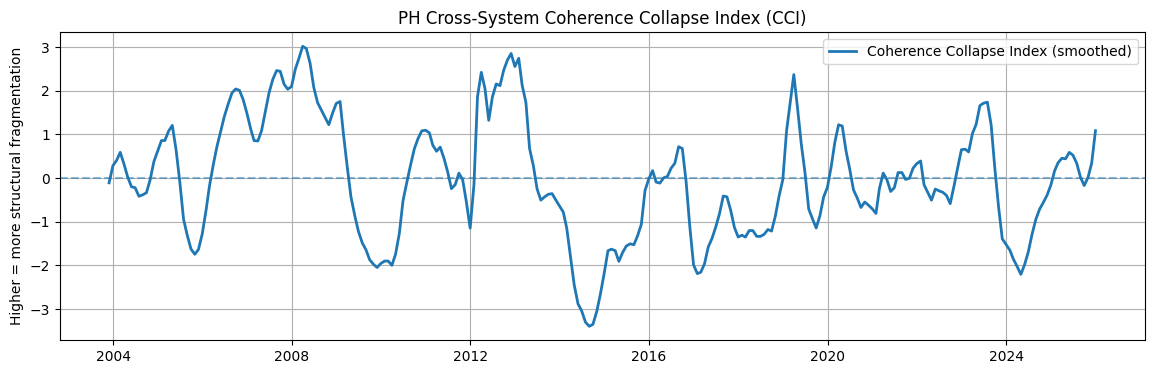

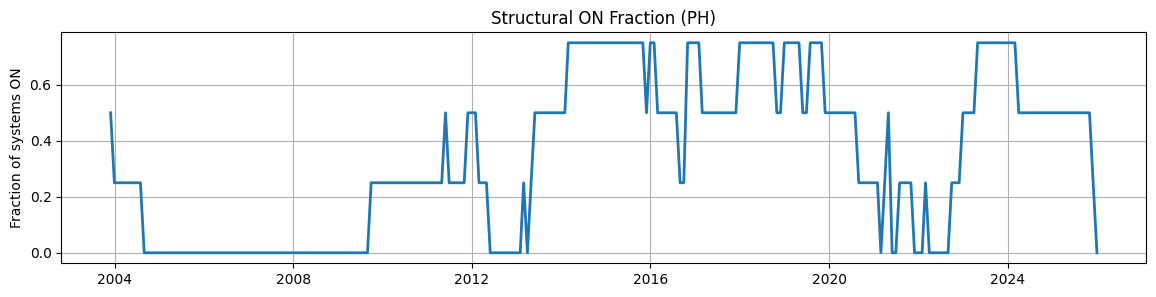

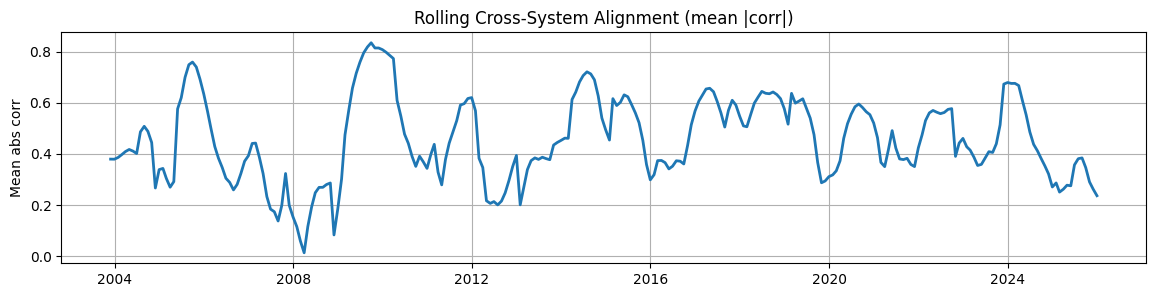

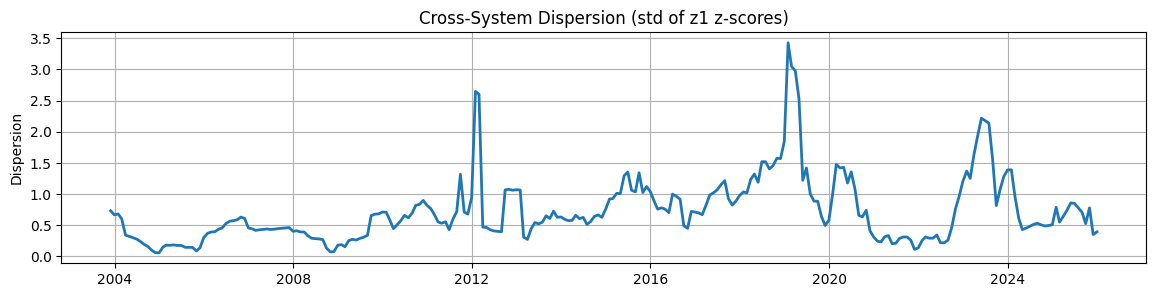

In [12]:
# C) Coherence components

# 1) Dispersion (higher = more disagreement / fragmentation)
dispersion = Z_z.std(axis=1)

# 2) Alignment (how similarly systems move): mean absolute correlation in a rolling window
CORR_WINDOW = 24  # months
corr_mean = pd.Series(index=Z_z.index, dtype=float)

cols = list(Z_z.columns)
for i in range(len(Z_z)):
    if i < CORR_WINDOW:
        corr_mean.iloc[i] = np.nan
        continue
    W = Z_z.iloc[i - CORR_WINDOW:i].dropna(axis=1, how="any")
    if W.shape[1] < 3:
        corr_mean.iloc[i] = np.nan
        continue
    C = W.corr().values
    # mean of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(C, k=1)
    corr_mean.iloc[i] = np.nanmean(np.abs(C[iu]))

# D) Build Coherence Collapse Index (CCI)

# Normalize components to comparable scale
on_z = (on_frac - on_frac.mean()) / (on_frac.std(ddof=0) + 1e-9)
disp_z = (dispersion - dispersion.mean()) / (dispersion.std(ddof=0) + 1e-9)
corr_z = (corr_mean - corr_mean.mean()) / (corr_mean.std(ddof=0) + 1e-9)

# Collapse intuition:
# - collapse when ON fraction falls (low on_z)
# - dispersion rises (high disp_z)
# - correlation falls (low corr_z)
#
# define:
# CCI_raw = (-on_z) + (disp_z) + (-corr_z)
CCI = (-on_z) + (disp_z) + (-corr_z)

cci_df = pd.DataFrame({
    "on_frac": on_frac,
    "dispersion": dispersion,
    "corr_mean": corr_mean,
    "CCI": CCI,
}).dropna(subset=["CCI"]).copy()

# Smooth for macro readability (optional)
SMOOTH = 3
cci_df["CCI_smooth"] = cci_df["CCI"].rolling(SMOOTH, min_periods=1).mean()

# ============================================================
# E) Visuals
# ============================================================

plt.figure(figsize=(14,4))
plt.plot(cci_df.index, cci_df["CCI_smooth"], linewidth=2, label="Coherence Collapse Index (smoothed)")
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("PH Cross-System Coherence Collapse Index (CCI)")
plt.ylabel("Higher = more structural fragmentation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(cci_df.index, cci_df["on_frac"], linewidth=2)
plt.title("Structural ON Fraction (PH)")
plt.ylabel("Fraction of systems ON")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,3))
plt.plot(cci_df.index, cci_df["corr_mean"], linewidth=2)
plt.title("Rolling Cross-System Alignment (mean |corr|)")
plt.ylabel("Mean abs corr")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,3))
plt.plot(cci_df.index, cci_df["dispersion"], linewidth=2)
plt.title("Cross-System Dispersion (std of z1 z-scores)")
plt.ylabel("Dispersion")
plt.grid(True)
plt.show()

In [13]:
# F) Simple regime labeling

# High CCI = fragmentation; low CCI = coherent regime
q_hi = cci_df["CCI_smooth"].quantile(0.85)
q_lo = cci_df["CCI_smooth"].quantile(0.15)

def label_cci(x):
    if x >= q_hi:
        return "FRAGMENTATION"
    if x <= q_lo:
        return "COHERENT"
    return "TRANSITION"

cci_df["coherence_regime"] = cci_df["CCI_smooth"].apply(label_cci)

print("Latest snapshot:")
latest = cci_df.iloc[-1]
print("Date:", latest.name.date())
print("CCI:", round(latest["CCI_smooth"], 3))
print("ON fraction:", round(latest["on_frac"], 3))
print("Alignment:", round(latest["corr_mean"], 3))
print("Dispersion:", round(latest["dispersion"], 3))
print("Regime:", latest["coherence_regime"])

Latest snapshot:
Date: 2025-12-31
CCI: 1.087
ON fraction: 0.0
Alignment: 0.236
Dispersion: 0.395
Regime: TRANSITION


In [14]:
# G) Export for Power BI / downstream notebooks

EXPORT_PATH = PROJECT_ROOT / "data" / "processed"
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

out_file = EXPORT_PATH / "ph_coherence_index.csv"
cci_df.reset_index().rename(columns={"index": "date"}).to_csv(out_file, index=False)
print("Saved:", out_file.resolve())

Saved: /Users/Rod/Desktop/macro-cycle-scanner/cycle-tda-lab/data/processed/ph_coherence_index.csv


Loaded cci_df: (266, 6)
Loaded df_all: (8460, 14)
Assets: ['Fed Funds', 'Gold (XAU)', 'HY OAS', 'Silver', 'US CPI', 'US M2']

=== Validation: CCI vs. S&P 500 Drawdowns ===
S&P 500: 121 rows


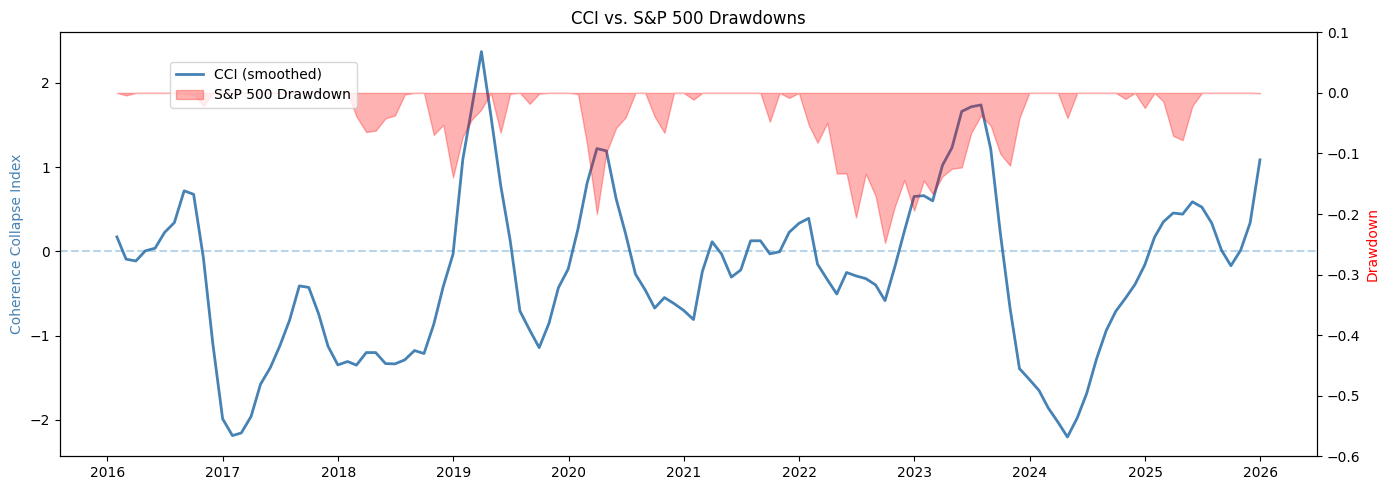


Lead/Lag Correlation:
  CCI lags by 6m: -0.036
  CCI lags by 3m: -0.173
  CCI lags by 1m: -0.282
  Contemporaneous: -0.303
  CCI leads by 1m: -0.341
  CCI leads by 3m: -0.353
  CCI leads by 6m: -0.233

=== Summary Table ===
     asset       era  n_obs  window  m  tau  mean_z1  p90_z1    cv  usability
 Fed Funds      Full    799      60  4    6   0.1738  0.6068 1.600      0.379
    HY OAS      Full    291      60  4    6   0.1845  0.3823 1.385      0.276
    HY OAS Post-1971    291      60  4    6   0.1845  0.3823 1.385      0.276
    Silver Post-1971    601      60  4    6   0.0979  0.1930 0.734      0.263
    Silver      Full   1302      60  4    6   0.1225  0.3137 1.486      0.211
Gold (XAU) Post-1971    601      60  4    6   0.0802  0.1774 0.888      0.200
 Fed Funds Post-1971    601      60  4    6   0.1158  0.3412 1.880      0.181
Gold (XAU)      Full   1140      60  4    6   0.0969  0.2219 1.518      0.146
    US CPI Post-1971    600      60  2    6   0.0095  0.0427 1.830      0

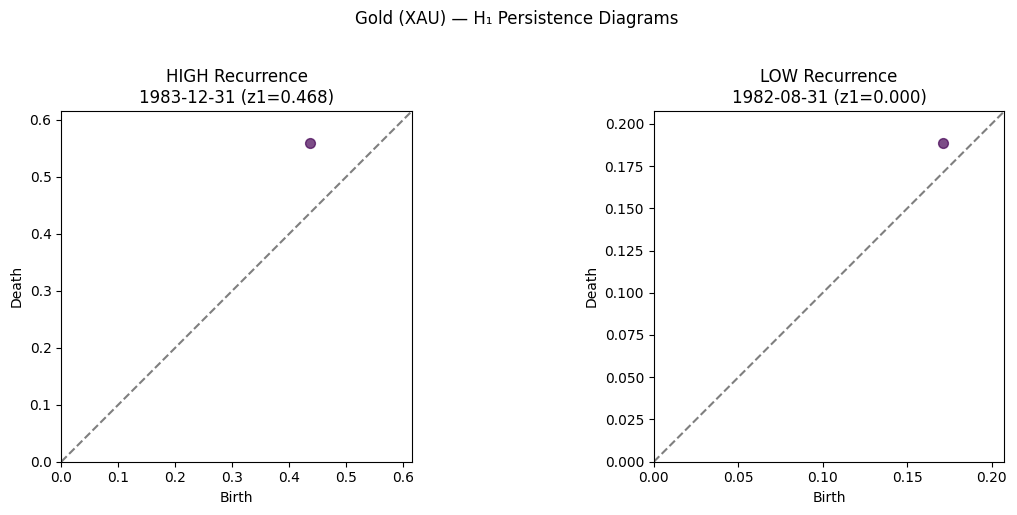


=== Current Regime Snapshot ===
Date:       2025-12-31
CCI:        1.087
ON frac:    0.000
Alignment:  0.236
Dispersion: 0.395
Regime:     TRANSITION

✓ Done. Outputs in: /Users/Rod/Desktop/macro-cycle-scanner/cycle-tda-lab/data/processed


In [15]:
# VALIDATION CELLS

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure src is in path
PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Imports
from cycle_tda.metrics import summarize_series, usability_score
from cycle_tda.embeddings import delay_embedding
from cycle_tda.ph import compute_diagrams

EXPORT_PATH = PROJECT_ROOT / "data" / "processed"

# Local loader
def load_series_robust(path):
    df = pd.read_csv(path)
    date_col = None
    for c in df.columns:
        if c.lower() == "date":
            date_col = c
            break
    if date_col is None:
        date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    value_col = None
    for c in df.columns:
        if c != date_col:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().sum() > 0:
                value_col = c
                break
    if value_col is None:
        raise ValueError(f"No numeric column found in {path}")
    return df.set_index(date_col)[value_col].dropna().sort_index()

# --- Load data ---
cci_df = pd.read_csv(
    EXPORT_PATH / "ph_coherence_index.csv",
    parse_dates=["date"]
).set_index("date")

df_all = pd.read_csv(
    EXPORT_PATH / "structural_ph_outputs.csv",
    parse_dates=["end_date"]
).rename(columns={"end_date": "date"}).set_index("date")

print("Loaded cci_df:", cci_df.shape)
print("Loaded df_all:", df_all.shape)
print("Assets:", sorted(df_all["asset"].unique()))

# ============================================================
# 8. CCI vs. S&P 500 Drawdowns
# ============================================================
print("\n=== Validation: CCI vs. S&P 500 Drawdowns ===")

sp500_path = PROJECT_ROOT / "data/raw/SP500_Monthly.csv"
sp500 = load_series_robust(sp500_path)
print(f"S&P 500: {len(sp500)} rows")

rolling_max = sp500.expanding().max()
drawdown = (sp500 - rolling_max) / rolling_max
common_idx = cci_df.index.intersection(drawdown.index)

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(cci_df.loc[common_idx].index, cci_df.loc[common_idx]["CCI_smooth"],
         color="steelblue", linewidth=2, label="CCI (smoothed)")
ax1.axhline(0, linestyle="--", alpha=0.3)
ax1.set_ylabel("Coherence Collapse Index", color="steelblue")

ax2 = ax1.twinx()
ax2.fill_between(drawdown.loc[common_idx].index, 0, drawdown.loc[common_idx].values,
                 color="red", alpha=0.3, label="S&P 500 Drawdown")
ax2.set_ylabel("Drawdown", color="red")
ax2.set_ylim(-0.6, 0.1)

plt.title("CCI vs. S&P 500 Drawdowns")
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.savefig(EXPORT_PATH / "cci_vs_drawdown.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nLead/Lag Correlation:")
cci_aligned = cci_df.loc[common_idx, "CCI_smooth"]
dd_aligned = drawdown.loc[common_idx]
corr_rows = []
for lag in [-6, -3, -1, 0, 1, 3, 6]:
    if lag > 0:
        corr = cci_aligned.corr(dd_aligned.shift(lag))
        label = f"CCI leads by {lag}m"
    elif lag < 0:
        corr = cci_aligned.shift(abs(lag)).corr(dd_aligned)
        label = f"CCI lags by {abs(lag)}m"
    else:
        corr = cci_aligned.corr(dd_aligned)
        label = "Contemporaneous"
    print(f"  {label}: {corr:.3f}")
    corr_rows.append({"lag_months": lag, "correlation": round(corr, 4), "label": label})

# --- Power BI exports ---
cci_dd_df = pd.DataFrame({
    "date": common_idx,
    "CCI_smooth": cci_aligned.values,
    "sp500_drawdown": dd_aligned.values,
})
cci_dd_df.to_csv(EXPORT_PATH / "cci_drawdown_aligned.csv", index=False)

pd.DataFrame(corr_rows).to_csv(EXPORT_PATH / "validation_correlations.csv", index=False)

q_hi = cci_df["CCI_smooth"].quantile(0.85)
q_lo = cci_df["CCI_smooth"].quantile(0.15)
pd.DataFrame([{"threshold": "q_hi", "value": q_hi}, {"threshold": "q_lo", "value": q_lo}]).to_csv(
    EXPORT_PATH / "regime_thresholds.csv", index=False
)

# ============================================================
# 9. Summary Table
# ============================================================
print("\n=== Summary Table ===")

rows = []
for (asset, era), g in df_all.groupby(["asset", "era"]):
    stats = summarize_series(g["z1"].values)
    rows.append({
        "asset": asset,
        "era": era,
        "n_obs": len(g),
        "window": int(g["window"].iloc[0]),
        "m": int(g["m"].iloc[0]),
        "tau": int(g["tau"].iloc[0]),
        "mean_z1": round(stats["mean"], 4),
        "p90_z1": round(stats["p90"], 4),
        "cv": round(stats["cv"], 3),
        "usability": round(usability_score(stats["p90"], stats["cv"]), 3),
    })

summary_df = pd.DataFrame(rows).sort_values("usability", ascending=False).reset_index(drop=True)
print(summary_df.to_string(index=False))
summary_df.to_csv(EXPORT_PATH / "asset_usability_summary.csv", index=False)

# ============================================================
# 10. Persistence Diagrams
# ============================================================
print("\n=== Persistence Diagrams ===")

g = df_all[(df_all["asset"] == "Gold (XAU)") & (df_all["era"] == "Post-1971")].copy()
high_z1_date = g["z1"].idxmax()
low_z1_date = g["z1"].idxmin()
print(f"High z1: {high_z1_date.date()} (z1={g.loc[high_z1_date, 'z1']:.3f})")
print(f"Low z1:  {low_z1_date.date()} (z1={g.loc[low_z1_date, 'z1']:.3f})")

xau = load_series_robust(PROJECT_ROOT / "data/raw/XAU_Monthly.csv")
xau = np.log(xau)

window = int(g["window"].iloc[0])
m = int(g["m"].iloc[0])
tau = int(g["tau"].iloc[0])

def get_window(end_date, series, w):
    idx = series.index.get_indexer([end_date], method="nearest")[0]
    return series.iloc[max(0, idx - w):idx].values

y_high = get_window(high_z1_date, xau, window)
y_low = get_window(low_z1_date, xau, window)

X_high = delay_embedding(y_high, m=m, tau=tau)
X_low = delay_embedding(y_low, m=m, tau=tau)

dgms_high = compute_diagrams(X_high, maxdim=1)
dgms_low = compute_diagrams(X_low, maxdim=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, dgms, title, date, z1_val in [
    (axes[0], dgms_high, "HIGH Recurrence", high_z1_date, g.loc[high_z1_date, 'z1']),
    (axes[1], dgms_low, "LOW Recurrence", low_z1_date, g.loc[low_z1_date, 'z1']),
]:
    dgm = dgms[1]
    if len(dgm) > 0:
        pers = dgm[:, 1] - dgm[:, 0]
        mask = np.isfinite(pers)
        if mask.any():
            ax.scatter(dgm[mask, 0], dgm[mask, 1], c=pers[mask], cmap="viridis", s=50, alpha=0.7)
            lim = np.nanmax(dgm[mask]) * 1.1
            ax.plot([0, lim], [0, lim], "k--", alpha=0.5)
            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)
    ax.set_title(f"{title}\n{date.date()} (z1={z1_val:.3f})")
    ax.set_xlabel("Birth")
    ax.set_ylabel("Death")
    ax.set_aspect("equal")

plt.suptitle("Gold (XAU) — H₁ Persistence Diagrams", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(EXPORT_PATH / "persistence_diagram_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# ============================================================
# 11. Final Snapshot
# ============================================================
print("\n=== Current Regime Snapshot ===")
latest = cci_df.iloc[-1]
print(f"Date:       {latest.name.date()}")
print(f"CCI:        {latest['CCI_smooth']:.3f}")
print(f"ON frac:    {latest['on_frac']:.3f}")
print(f"Alignment:  {latest['corr_mean']:.3f}")
print(f"Dispersion: {latest['dispersion']:.3f}")
print(f"Regime:     {latest['coherence_regime']}")

# Latest snapshot export (Power BI)
macro_path = EXPORT_PATH / "macro_advisory_state.csv"
snapshot_row = {
    "date": latest.name,
    "CCI_smooth": latest["CCI_smooth"],
    "on_frac": latest["on_frac"],
    "corr_mean": latest["corr_mean"],
    "dispersion": latest["dispersion"],
    "coherence_regime": latest["coherence_regime"],
}
if macro_path.exists():
    macro_df = pd.read_csv(macro_path, parse_dates=["date"])
    latest_date = pd.Timestamp(latest.name)
    match = macro_df[macro_df["date"] == latest_date]
    if len(match) > 0:
        r = match.iloc[0]
        snapshot_row["macro_stress_score"] = r.get("macro_stress_score", None)
        snapshot_row["narrative"] = r.get("narrative", None)
pd.DataFrame([snapshot_row]).to_csv(EXPORT_PATH / "latest_snapshot.csv", index=False)

print(f"\n✓ Done. Outputs in: {EXPORT_PATH}")
